# Response and Resolution Studies for the Trigger Level Analysis at the ATLAS Experiment

## Abstract
When particles collide at the Large Hadron Collider, the invariant mass of new particles can be derived by detecting their decay products. The Trigger Level Analysis (TLA) at the ATLAS experiment uses partly reconstructed particle collision events for its analysis. The smaller data size allows TLA to obtain a much larger number of events and a smaller statistical uncertainty. This notebook presents the data processing and analysis used to plot the invariant mass response for the different TLA calibration steps. This allows us to see if any calibration step introduces signal-like features. The insights gained from the response are also used to estimate the invariant mass resolution of the analysis and thereby derive an optimal histogram binning for the main observable of the analysis.

## Introduction
### Jets and Invariant Mass
When particles collide at the Large Hadron Collider (LHC) at CERN, it is possible that new particles are created and that these particles decay into decay products. The ATLAS detector allows us to study these decay products and learn about the properties of the original particle. Due to the nature of the strong force, one of the most common observable objects at ATLAS are collimated particle showers. From the detector data, we can then group the energy deposits of these particle showers into an object called a jet. By studying these jets we can learn about potential particles created in the collision, hopefully, dark matter.

![alt text](images/jets.png "Title")

### Invariant Mass Response
Particle collision event data at the LHC uses a specialized data framework and file format called ROOT. For each particle collision event we can access, among other things, the jet's energy and momentum (including direction in the cylindrical coordinates $\eta$ and $\phi$). With this, we can represent the jets as Lorentz vectors and calculate the invariant mass (mjj) of the particle formed by the collision.

Before we run the following notebook, a C++ algorithm has processed millions of simulated particle collision events called Monte Carlo simulation (MC). With simulated events we can look at the energy and momentum of particles and jets as they would look purely theoretically, we call these jets "truth jets". We can also simulate each particle's propagation and interaction with the different components and its final digital readout. This gives us what we call "reconstructed jets".

Since truth jets only exist in simulation, the simulations allow us to look at the invariant mass ratio between the reconstructed jets and truth, which we call response. 

$$ R = \frac{m_{jj_{Reco}}}{m_{jj_{Truth}}} $$

This response gives us an idea of how much jets measured in reality (reconstructed jets), differ from the "actual" jets (truth jets). This in turn gives us important information about our detector, our calibration, and data processing.

### Jet Calibration
Apart from calibration of the individual detector components at ATLAS, we use an MC-driven calibration where we derive different calibration constants and curves by comparing reconstructed objects to truth objects. The figure below shows the calibration steps of the trigger level analysis. Where the final step corrects for disagreement between the MC simulations and actual data.

![alt text](images/calibration.png "Title")

Each calibration step above brings our jets to a different "energy scale": EM, Pileup, ETaJES, GSC, in-situ. In this notebook, we will look at the jet invariant mass response vs the true invariant mass for the first four energy scales in different slices of the spatial dimension $\eta$. By looking at the response at each energy scale we can see if any step of the calibration introduces any bumps or features, which will interfere with our final analysis looking for new particles.


### Invariant Mass Resolution
Since the dijet invariant mass ($m_{jj}$) distribution is the main observable for TLA in the search for new physics, it is important to use a suitable $m_{jj}$ binning. There are two conflicting considerations in deriving this binning.
1. Bins should be wider than the detector resolution to limit the effect from event migrations between bins.
2. A narrow binning allows a possible signal excess to spread over multiple bins, allowing for multiple inputs to a fit.

The binning is derived by an estimated detector resolution, which we define as the standard deviation of the fitted mjj response distribution at a given truth mjj


### Data Processing in this Notebook
The C++ algorithm which was run before this notebook outputs 3D histograms with mjj response, truth mjj, and truth $\eta$ on the x, y, and z-axis respectively. This notebook transforms this 3D histogram into more understandable plots such as mjj response vs truth mjj using the following steps:

* Fitting
    * 3D histograms are sliced on the z-axis and projected into a 2D histogram (each slice is usuallly in truth $\eta$)
    ![alt text](images/3d_to_2d.png "Title")
    * 2D histograms are sliced in bins on the y axis and projected into 1D histograms (each slice is usually a truth mjj bin width)
    * 1D histograms are fitted with a gaussian using an external python script called "JESBalanceFitter"
    * Information about the gaussian fits are written to disk for future processing
    ![alt text](images/2d_to_1d.png "Title")
* Plotting
    * A set of the available fit information is read, one per initial 3D histogram
    * For each 3D histogram $\eta$ slice, the fit mean is plotted at the corresponding 1D histograms mjj bin center. Providing an mjj response vs truth mjj plot for all 3D histograms, for all $\eta$ slices
    ![alt text](images/1d_to_graph.png "Title")

### Final Notes
In this notebook, we will also look at a quantity called "transverse momentum" (pT) alongside mjj, which will be treated the same as mjj in the data processing. We will also look at two $\eta$ slices, -2.8 to 2.8, and -0.6 to 0.6. This means that we expect 2*2=4 plots in total, with 4 data series in each plot (because we are looking at 4 different 3D histograms). 

## Response
### Loading the 3D histograms

In [1]:
import ROOT
from JES_BalanceFitter import JES_BalanceFitter
import numpy as np
import pandas as pd
import pickle

TClassTable::Add:0: RuntimeWarning: class timespec already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<TString*,vector<TString> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<int*,vector<int> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<string*,vector<string> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<const char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<TString*,vector<TString> > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<const TString*,vector<TString> > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gn

Welcome to JupyROOT 6.20/00


Set the base path to be independent to the user and define the paths to the different data sets

In [2]:
pathList=!pwd
path=pathList[0]
listOfRootFilePaths = [path+"/data/v14/merged_mc16d_mjj_v14.root",
                       path+"/data/v15/merged_mc16d_mjj_v15.root",
                       path+"/data/v18/merged_mc16a_mjj_v18.root",
                       path+"/data/v19/merged_mc16a_mjj_v19.root",
                      ]

Create a directory to house all the output plots

In [3]:
!mkdir output

Set parameters for the slicing and projecting

In [4]:
slicingAxis = "z"
slices = [[-2.8,2.8],[-0.6,0.6]]

projectionAxis = "y"
projectionRebinWidth = 2

responseAxis = "x"

Set parameters for the gaussian fit

In [5]:
nSigmaForFit = 1.3
fitOptString = "RESQ"

We mainly loop for each file path, for each slice in $\eta$. Where we first create an empty dataframe for that slice, with one series for each 3D histogram. For each 3D histogram we slice, project, and fit the response and save the fit variables and others to the dataframe.

The number of dataframes will be:
$$n_{DataFrames}=n_{filePaths}*n_{slices}$$

For each file path we will get:
$$n_{responsePlots}=n_{responseVariables}*n_{slices}$$

Where the number of response variables discussed under final notes in the introduction

In [6]:
for rootFilePath in listOfRootFilePaths:
    inFile = ROOT.TFile.Open(rootFilePath)
    
    for currentSlice in slices:
        inFile = ROOT.TFile.Open(rootFilePath)
        listOfKeys = inFile.GetListOfKeys()

        l=[]
        for key in listOfKeys:
            TH3Name = key.GetName()
            if TH3Name[0:9] != "scaled_h_":
                continue
            elif inFile.Get(TH3Name).GetEntries()==0.0:
                print("WARNING:",TH3Name," is empty!")
                continue
            else:
                l.append(pd.Series({ "x"             :[],
                                     "y"             :[],
                                     "xError"        :[],
                                     "yError"        :[],
                                     "sigma"         :[],
                                     "sigmaError"    :[],
                                     "sigmaOverY"    :[],
                                     "sigmaOverYError"    :[],
                                     "fitAmplitude"  :[],
                                     "fitMin"        :[],
                                     "fitMax"        :[],

                                     "TH1BinEdges"   :[],
                                     "TH1BinEntries" :[],
                                     "TH1BinErrors"  :[],
                                   },
                                      name=TH3Name))
        dfPath = rootFilePath.split(".")[0]+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
        print(dfPath)
        df = pd.DataFrame(l)
    
        for TH3Name in df.index:
            inTH3 = inFile.Get(TH3Name)
            h3D = inTH3.Clone()

            #set JES_BalanceFitter options
            JESBfitter = JES_BalanceFitter(nSigmaForFit)
            JESBfitter.SetGaus()
            JESBfitter.SetFitOpt(fitOptString)

            listOfTH1Content=[]
            listOfGaussians=[]

            xnBins = h3D.GetXaxis().GetNbins()
            ynBins = h3D.GetYaxis().GetNbins()

            #Get the bin which corresponds to the desired slice axis range
            if slicingAxis == "y":
                h3D.GetYaxis().SetRangeUser(currentSlice[0], currentSlice[1])     
            elif slicingAxis == "z":
                h3D.GetZaxis().SetRangeUser(currentSlice[0], currentSlice[1]) 

            #Project the 3D histogram with the set y-axis range
            h2D=h3D.Project3D(responseAxis + projectionAxis)

            #rebin according to the desired rebinningFactor
            h2D.RebinX(projectionRebinWidth)

            currentRebinnedBin = 1
            for currentRebinnedBin in range(1, h2D.GetNbinsX()+1):
                #name of projection
                projName = "slice"+str(currentSlice[0])+"to"+str(currentSlice[1])+"_projectionBin"+str(h2D.GetXaxis().GetBinLowEdge(currentRebinnedBin))+"to"+str(h2D.GetXaxis().GetBinUpEdge(currentRebinnedBin))

                #take projection
                h1D=h2D.ProjectionY(projName, currentRebinnedBin, currentRebinnedBin)

                #skip empty bins
                if h1D.GetEntries() == 0:
                    #print("empty 1D hist, skipping!")
                    continue

                #fitting limits
                fitMax = h1D.GetMean() + nSigmaForFit * h1D.GetRMS()
                fitMin = h1D.GetMean() - nSigmaForFit * h1D.GetRMS()

                #obtain fit using JES_BalanceFitter and associate it to the TH1           
                JESBfitter.Fit(h1D, fitMin, fitMax)
                fit = JESBfitter.GetFit()
                histFit = JESBfitter.GetHisto()
                Chi2Ndof = JESBfitter.GetChi2Ndof()
                histFit.GetListOfFunctions().Add(fit)

                binEdges=[]
                binEntries=[]
                binErrors=[]
                for i in range(1, h1D.GetNbinsX()+1):#Plus one to include last bin, this is simple python syntax
                  binEdges.append(h1D.GetXaxis().GetBinLowEdge(i))
                  binEntries.append(h1D.GetBinContent(i))
                  binErrors.append(h1D.GetBinError(i))
                binEdges.append(h1D.GetXaxis().GetBinUpEdge(h1D.GetNbinsX()))# Append the right most edge

                df["x"].loc[TH3Name].append(float(h2D.GetXaxis().GetBinCenter(currentRebinnedBin)))
                df["y"].loc[TH3Name].append(float(fit.GetParameter(1)))
                df["xError"].loc[TH3Name].append(float((h2D.GetXaxis().GetBinWidth(currentRebinnedBin)/2.0)))#half bin width
                df["yError"].loc[TH3Name].append(float(fit.GetParError(1)))
                df["sigma"].loc[TH3Name].append(float(fit.GetParameter(2)))
                df["sigmaError"].loc[TH3Name].append(float(fit.GetParError(2)))
                try:
                    df["sigmaOverY"].loc[TH3Name].append(float(fit.GetParameter(2) / float(fit.GetParameter(1))))
                    df["sigmaOverYError"].loc[TH3Name].append(np.sqrt((fit.GetParError(2)/fit.GetParameter(2))**2+(fit.GetParError(1)/fit.GetParameter(1))**2))
                except:
                    df["sigmaOverY"].loc[TH3Name].append(0)
                    df["sigmaOverYError"].loc[TH3Name].append(0)

                df["TH1BinEdges"].loc[TH3Name].append(binEdges)
                df["TH1BinEntries"].loc[TH3Name].append(binEntries)
                df["TH1BinErrors"].loc[TH3Name].append(binErrors)

        
        df.to_pickle(dfPath+".pickle")

    inFile.Close()


/home/pekman/responseStudies-alex-exook/data/v14/merged_mc16d_mjj_v14_z[-2.8,2.8]
/home/pekman/responseStudies-alex-exook/data/v14/merged_mc16d_mjj_v14_z[-0.6,0.6]
/home/pekman/responseStudies-alex-exook/data/v15/merged_mc16d_mjj_v15_z[-2.8,2.8]
/home/pekman/responseStudies-alex-exook/data/v15/merged_mc16d_mjj_v15_z[-0.6,0.6]
/home/pekman/responseStudies-alex-exook/data/v18/merged_mc16a_mjj_v18_z[-2.8,2.8]
/home/pekman/responseStudies-alex-exook/data/v18/merged_mc16a_mjj_v18_z[-0.6,0.6]
/home/pekman/responseStudies-alex-exook/data/v19/merged_mc16a_mjj_v19_z[-2.8,2.8]
/home/pekman/responseStudies-alex-exook/data/v19/merged_mc16a_mjj_v19_z[-0.6,0.6]


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


### Plotting

Make some helper functions which return wether a data series is from data or MC simulation, or Online or Offline objects. These are mostly used for the plot legends

In [7]:
def isItDataOrMC(rootFilePath):
    if("mc" in rootFilePath.split("/")[-1]):
        return "MC"
    elif("data" in rootFilePath.split("/")[-1]):
        return "Data"
    else:
        "Cannot determine if it is Data or MC"
    
def isItOnlineOrOffline(dfIndex):
    if("Online" in dfIndex):
        return "Online"
    elif("Offline" in dfIndex):
        return "Offline"
    else:
        return "Cannot determine if it is Online or Offline"

Set plotting parameters such as axis ranges, axis labels, legend titles, and energy scales to skip

In [8]:
xAxisUnit = "mjj"

xAxisLabel = "Truth $"+xAxisUnit[0]+"_{"+xAxisUnit[1:].upper()+"}$"
yAxisLabel = "$"+xAxisUnit[0]+"_{"+xAxisUnit[1:].upper()+"}$ Response"

skipEnergyScales = ["SmearedMomentum"]

responseLegendTitle = ["Energy Scale Response",
               "$\eta = $",
              ]

resolutionLegendTitle = ["Online vs. Offline Resolution",
               "$\eta = $",
              ]
resolutionRatioLegendTitle = ["Resolution Ratio:",
              ]

xLimits = (100,5000)
yLimits = (0.5,1.2)

Import packages needed for plotting and fitting

In [9]:
import scipy as scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import mplhep as hep

For each filepath and slice, we plot the response for the desired xAxisUnit (for example invariant mass: mjj), skipping the energy scales we want to skip

'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bolditalic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bolditalic.otf' can not be subsetted into a Ty

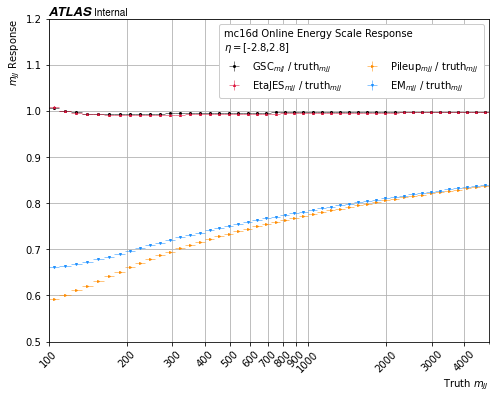

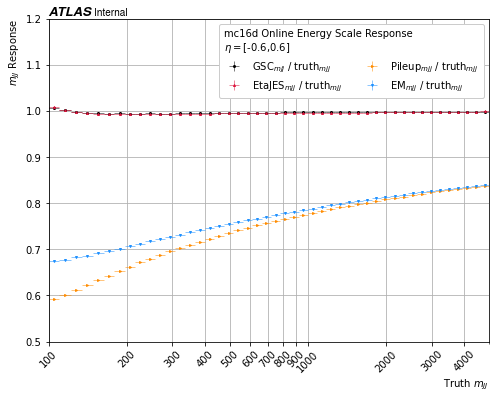

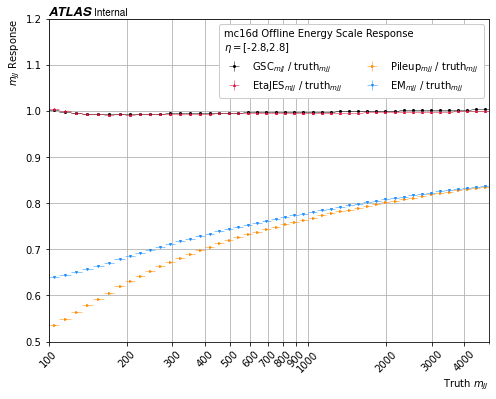

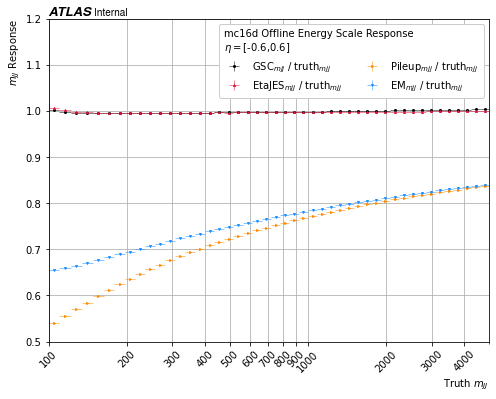

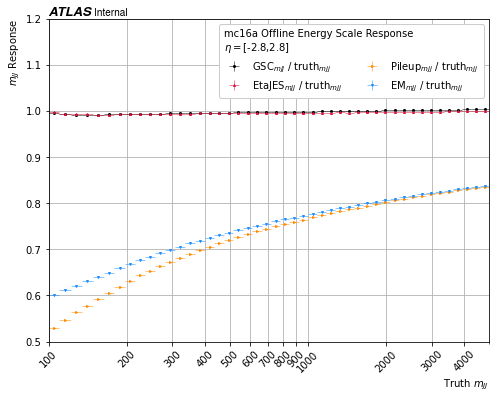

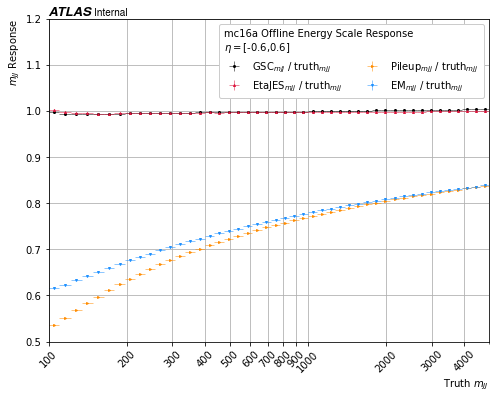

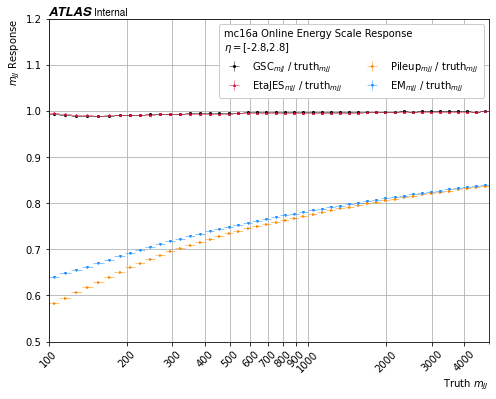

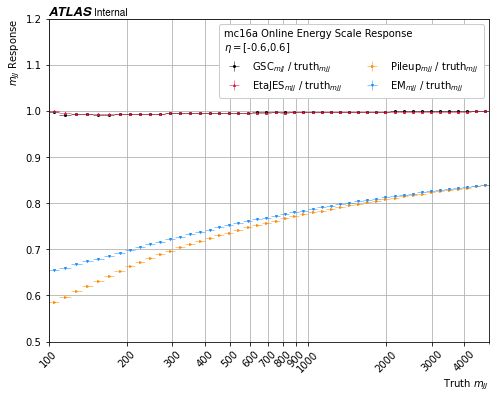

In [10]:
for rootFilePath in listOfRootFilePaths:
    for currentSlice in slices:
        f, ax = plt.subplots(figsize=(18.5*(1/2.54), 13.725*(1/2.54)),sharex=True)
        f.subplots_adjust(left=0.11, right=0.95, bottom=0.12, top=0.95)
        dfPath = rootFilePath.split(".")[0]+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
        df = pd.read_pickle(dfPath+".pickle")
        # Get data information based on root file path and TH3 name
        DataOrMC = isItDataOrMC(rootFilePath)
        OnlineOrOffline = isItOnlineOrOffline(df.index[0])
        campagin = rootFilePath.split("/")[-1].split(".")[0].split("_")[1]
        # Define markers and colors for plots
        markers = ["o","^",">","v","<"]
        colors = ["black","crimson","darkorange","dodgerblue","forestgreen"]
        
        # Iterate over TH3s in data frame
        i=0
        for TH3Name in reversed(df.index):
            skipping = False
            if xAxisUnit not in TH3Name:
                skipping = True
            for skippedEnergyScales in skipEnergyScales:
                if skippedEnergyScales in TH3Name:
                    skipping = True
            if skipping: continue
                
            # Get data information based on TH3 name
            numeratorEnergyScale = TH3Name.split("_-_")[1].split("_")[0].split("-")[0]
            denominatorEnergyScale = TH3Name.split("_-_")[1].split("_")[2].split("-")[0]
            if denominatorEnergyScale == "":denominatorEnergyScale = TH3Name.split("_-_")[1].split("_")[2].split("-")[1]

            # Assign data from dataframe
            x=df["x"].loc[TH3Name]
            y=df["y"].loc[TH3Name]
            x_error=df["xError"].loc[TH3Name]
            y_error=df["yError"].loc[TH3Name]

            # Plot data
            ax.errorbar(x, y, yerr=y_error, xerr=x_error,
                        linestyle='None',
                        marker=markers[i],
                        color=colors[i],
                        markersize=2,
                        linewidth=0.5,
                        label=numeratorEnergyScale+"$_{"+xAxisUnit+"}$"+" / "+denominatorEnergyScale+"$_{"+xAxisUnit+"}$",
                       )
            i+=1

        # Add legend
        leg = ax.legend(borderpad=0.5, loc=1, ncol=2, frameon=True,facecolor="white",framealpha=1)
        leg._legend_box.align = "left"
        leg.set_title(campagin+" "+OnlineOrOffline+" "+responseLegendTitle[0]+"\n"+responseLegendTitle[1]+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]")

        # Set limits and labels
        ax.set_xlim(xLimits)
        ax.set_ylim(yLimits)

        # Set log scale
        ax.set_xscale("log")

        # Set axis labels
        ax.set_xlabel(xAxisLabel, ha='right',x=1.0)
        ax.set_ylabel(yAxisLabel, ha='right', y=1.0)


        # Add grid and custom tick markers
        ax.grid(True)
        tickList = [1,2,3,4,5,6,7,8,9,
        10,20,30,40,50,60,70,80,90,
        100,200,300,400,500,600,700,800,900,
        1000,2000,3000,4000,5000,6000,7000,8000,9000,
        10000]
        ax.set_xticks(tickList[tickList.index(xLimits[0]):tickList.index(xLimits[1])])
        ax.set_xticklabels(tickList[tickList.index(xLimits[0]):tickList.index(xLimits[1])])
        plt.xticks(rotation=45)

        # Add ATLAS label
        hep.atlas.text("Internal",ax=ax)

        #f.savefig("output/"+dfPath.split("/")[-1]+"_"+xAxisUnit+"_"+".pdf")
        f.savefig("output/"+campagin+"_"+OnlineOrOffline+"_"+xAxisUnit+"_"+"response"+"_"+"eta"+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"".pdf")

To be able to see how good the 1D response distributions are for each data point in the above plots, we create an interactive plot using bokeh. In the first half we just create a normal bokeh plot. In the second part we loop over each datapoint in the plot, and create a histogram based on the 1D histogram data saved for each datapoint in the dataframe. For these subplots wedump a json item into a list, which is later used for a custom hover tooltip in bokeh.

For best results, un-click the top hover tool in the right menu like this:
![alt text](images/like_this.png "Title")

In [11]:
import json
from bokeh.embed import json_item
from bokeh.models import ColumnDataSource, CustomJSHover, HoverTool
from bokeh.plotting import figure, show, output_notebook

rootFilePath = listOfRootFilePaths[0]
TH3Name = "scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta"
currentSlice=[-2.8,2.8]
dfPath = rootFilePath.split(".")[0]+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
df= pd.read_pickle(dfPath+".pickle")
series = df.loc[TH3Name]

x = series['x']
y = series['y']

source = ColumnDataSource(data={'x':x,'y':y})
#source = ColumnDataSource(data=dict(x=[1, 4, 8], y=[2, 8, 5]))

p = figure(plot_width=800, plot_height=600,
           x_axis_label='$m_{jj}$ [GeV]', y_axis_label='$m_{jj}$ Response',
           x_range=(100,5000),y_range=(0.97,1.01),
           x_axis_type="log",
           tools="pan,box_zoom,wheel_zoom,reset",
           tooltips=[('$m_{jj}$','@x'),('Response','@y')]
          )

p.circle('x','y',source=source,legend_label=TH3Name)

listOfOut = []
for i,TH1 in enumerate(x):
    p2 = figure(title="mjj = "+str(TH1),plot_height=400, plot_width=600, toolbar_location=None,
                x_axis_label='$m_{jj} Response$ [GeV]', y_axis_label='Entries',
                x_range=(0.5,1.5)
               )
    p2.quad(top=series["TH1BinEntries"][i], bottom=0, left=series["TH1BinEdges"][i][:-1], right=series["TH1BinEdges"][i][1:],
            fill_color="navy",
            line_width=0,
           )
    listOfOut.append(json.dumps(json_item(p2, "tooltip-plot")))

source.data['plot'] = listOfOut

code="""
    Bokeh.embed.embed_item(JSON.parse(value))
    return ""
"""

p.add_tools(HoverTool(
    tooltips='<div id="tooltip-plot">@plot{custom}</div>',
    formatters={ '@plot': CustomJSHover(code=code) }
))

output_notebook()
show(p)

Loading BokehJS ...

## Resolution
For the resolution we want to compare the resolution of the TLA "online" mjj, to the ATLAS main physics analysis' "offline" mjj. Therefore we select only two of the root file paths defined in the beginning of the notebook

In [12]:
listOfComparisonPaths = [
                listOfRootFilePaths[0],
                listOfRootFilePaths[1],
                ]

We then select the final enegy scale and response variable, since comparing all of them would be too many, and in the end, it is the final energy scale that really matters

In [13]:
energyScale = "GSC"
xAxisUnit = "mjj"

Next we define a function taking the form of the energy resolution of a calorimeter detector. We will use this to fit our data, since ATLAS uses a calorimeter to measure energy

In [14]:
def resolutionFunc(x,a,b,c):
    return np.sqrt((a/np.sqrt(x))**2+(b/x)**2+c**2)

Lastly we loop over the $\eta$ slices. For each slice we loop over the root file paths which we want to compare, one with online histograms and one with offline. For each file we select the #D histogram name which corresponds to our energyscale and response variable defined above.

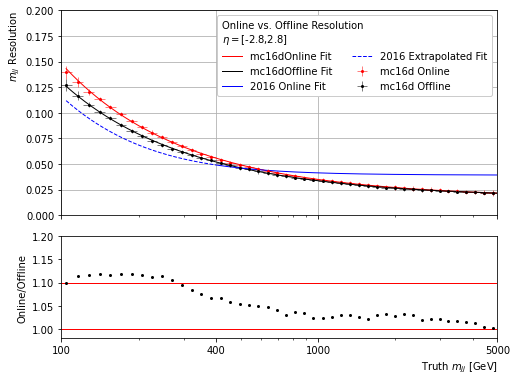

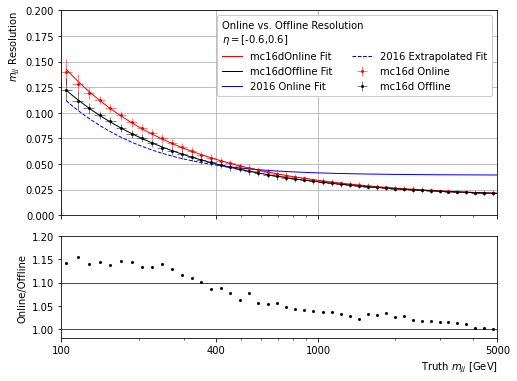

In [15]:
linspace=np.linspace(x[0],x[-1],num=10000)
color_list=["red","black"]

for currentSlice in slices:
    f, axisList = plt.subplots(2,1,figsize=(18.5*(1/2.54), 13.725*(1/2.54)),sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    x_list = []
    y_list = []
    
    for i,rootFilePath in enumerate(listOfComparisonPaths):
        dfPath = rootFilePath.split(".")[0]+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
        df= pd.read_pickle(dfPath+".pickle")
        
        # Get data information based on root file path and TH3 name
        DataOrMC = isItDataOrMC(rootFilePath)
        OnlineOrOffline = isItOnlineOrOffline(df.index[0])

        # Assign data from dataframe
        TH3Name = df[[((energyScale in s) and (xAxisUnit in s)) for s in df.index]].index[0]
        x=df["x"].loc[TH3Name]
        x_list.append(x)
        y=df["sigmaOverY"].loc[TH3Name]
        y_list.append(y)
        x_error=df["xError"].loc[TH3Name]
        y_error=df["sigmaOverYError"].loc[TH3Name]

        axisList[0].errorbar(x, y, yerr=y_error, xerr=x_error,
                    linestyle='None',
                    marker="o",
                    color=color_list[i],
                    markersize=2,
                    linewidth=0.5,
                    label=rootFilePath.split("/")[-1].split("_")[1]+" "+OnlineOrOffline)

        popt_resolutionFunc, pcov_resolutionFunc = curve_fit(resolutionFunc, x, y, sigma=y_error)


        axisList[0].plot(linspace, resolutionFunc(linspace,*popt_resolutionFunc), lw=1, label=rootFilePath.split("/")[-1].split("_")[1]+OnlineOrOffline+" Fit",color=color_list[i])

    axisList[0].plot(linspace[240:], resolutionFunc(linspace[240:],0.27,10.6,0.039), lw=1, label=r'2016 Online Fit',color="blue")
    axisList[0].plot(linspace[:240], resolutionFunc(linspace[:240],0.27,10.6,0.039), lw=1, label=r'2016 Extrapolated Fit',color="blue",linestyle='dashed')


    # Legend
    leg = axisList[0].legend(borderpad=0.5, frameon=True, loc=1,ncol=2,facecolor="white",framealpha=1.0)
    leg.set_title(resolutionLegendTitle[0]+"\n"+resolutionLegendTitle[1]+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]")
    leg._legend_box.align = "left"

    axisList[0].set_ylabel(r'$m_{jj}$ Resolution', ha='right', y=1.0)
    
    hep.atlas.text("Simulation Internal",ax=ax)

    axisList[0].set_xlim(100,5000)
    axisList[0].set_xscale("log")
    axisList[0].set_ylim(0.00,0.2)

    axisList[0].grid()

    axisList[1].errorbar(np.array(x_list[0]),np.array(y_list[0])/np.array(y_list[1]),linestyle='None',marker="o",color="black",markersize=2,linewidth=0.5,label="Ratio")

    axisList[1].set_xlim(100,5000)
    axisList[1].set_ylim(0.98,1.2)
    axisList[1].plot( [100,5000], [1.0,1.0],color="red",lw=1)
    axisList[1].plot( [100,5000], [1.1,1.1],color="red",lw=1)

    axisList[1].set_axisbelow(True)
    axisList[1].set_xticks([100,400,1000,5000])
    axisList[1].set_xticklabels([100,400,1000,5000])

    axisList[1].set_xlabel(r"Truth $m_{jj}$ [GeV]", ha='right', x=1.0)
    axisList[1].set_ylabel(r"Online/Offline")

    plt.tight_layout()

    f.savefig("output/"+rootFilePath.split("/")[-1].split("_")[1]+"_"+"onlineVsOffline"+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"+".pdf")

## Resolution Based Binning
We will use the resolution to estimate the resolution of the detector, and with that obtain the optimal mjj histogram binning.

Firstly we define the same resolution function as before

In [16]:
def resolutionFunc(x,a,b,c):
    return np.sqrt((a/np.sqrt(x))**2+(b/x)**2+c**2)

Next we pick the dataframe we want to use for obtaining the new binning. For this we want to use the highest energy scale, GSC, the large $\eta$ slice -2.8 to 2.8, from the mc16d Online filepath.

In [17]:
rootFilePath = listOfRootFilePaths[0]
TH3Name = "scaled_h_-_GSC-Online_over_-truth_-_mjj_-_eta"
currentSlice=[-2.8,2.8]
dfPath = rootFilePath.split(".")[0]+"_"+slicingAxis+"["+str(currentSlice[0])+","+str(currentSlice[1])+"]"
df= pd.read_pickle(dfPath+".pickle")

Next we assign variables to the appropriate lists of the dataframe and fit this data with a resolution function

In [18]:
x=df["x"].loc[TH3Name]
y=df["sigmaOverY"].loc[TH3Name]
x_error=df["xError"].loc[TH3Name]
y_error=df["sigmaOverYError"].loc[TH3Name]

popt_resolutionFunc, pcov_resolutionFunc = curve_fit(resolutionFunc, x, y, sigma=y_error)

We want at least one bin edge to be at 531 GeV, since this bin edge coincides with previous studies. We therefore start at 531 and loop down to 100. For each iteration we define a bin width as the rounded integer of the resolution function evaluated at the current bin edge, times the current bin edge

In [19]:
currentEdge = 531
bins1 = [currentEdge]
while (currentEdge > 100):
    currentBinwidth = int(round( resolutionFunc(currentEdge, *popt_resolutionFunc)*currentEdge ))
    currentEdge -= currentBinwidth
    bins1.append(currentEdge)
bins1=bins1[1:]

We then do the same but reverse form 531 up to 5000 and sort the bin edges in ascending order

In [20]:
currentEdge = 531
bins2 = [currentEdge]
while (currentEdge < 5000):
    currentBinwidth = int(round( resolutionFunc(currentEdge, *popt_resolutionFunc)*currentEdge ))
    currentEdge += currentBinwidth
    bins2.append(currentEdge)
bins=bins1+bins2
bins.sort()

print("Bin edges: \n",bins)

Bin edges: 
 [92, 107, 122, 138, 154, 171, 188, 206, 224, 243, 262, 282, 302, 322, 343, 365, 387, 410, 433, 457, 481, 506, 531, 556, 582, 608, 635, 662, 690, 719, 748, 778, 808, 839, 871, 903, 936, 970, 1004, 1039, 1075, 1111, 1148, 1186, 1225, 1264, 1304, 1345, 1387, 1429, 1472, 1516, 1561, 1607, 1654, 1702, 1750, 1799, 1849, 1900, 1952, 2005, 2059, 2114, 2170, 2227, 2285, 2344, 2404, 2465, 2528, 2592, 2657, 2723, 2790, 2858, 2928, 2999, 3071, 3145, 3220, 3296, 3374, 3453, 3533, 3615, 3698, 3783, 3869, 3957, 4046, 4137, 4230, 4324, 4420, 4518, 4617, 4718, 4821, 4926, 5033]


Next we write the binning to a JSON file for easy sharing

In [21]:
import json
#Create JSON and ROOT binning
mjjBins = {
    'TLAdefault':   bins,
    'TLAlowMu'  :   []
}

outfile = open('output/mjjBins.json','w')
outfile.write(json.dumps(mjjBins, sort_keys=True, indent=4, separators=(',', ': ')))
outfile.close()